In [1]:
import shutil
shutil.unpack_archive("dataset_hist_structures 2.zip")

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

2024-11-18 07:13:34.019294: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 07:13:34.060272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB


2024-11-18 07:13:36.014134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### Plot the sample images(8-10) from each class/category and gain understanding about each class. You can use the OpenCV open source library for this task.

Category: altar


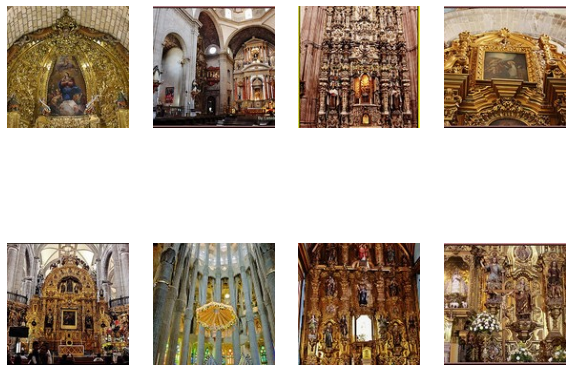

Category: flying_buttress


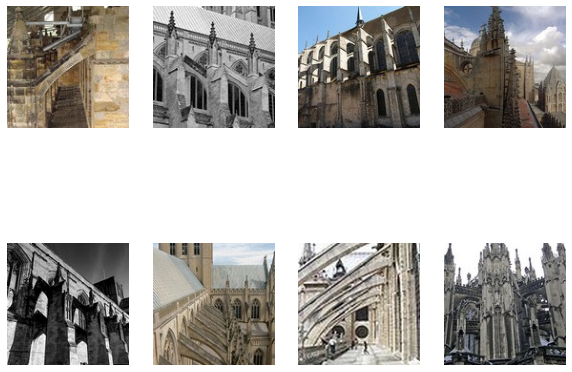

Category: vault


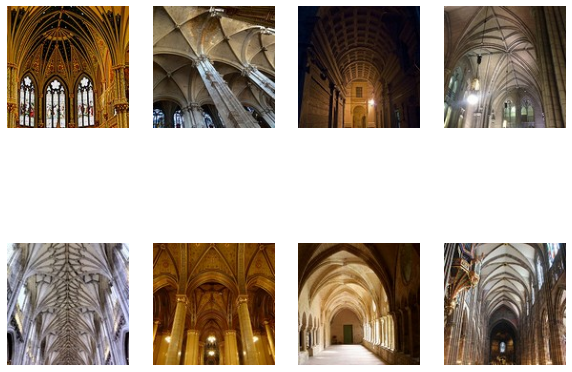

Category: dome(inner)


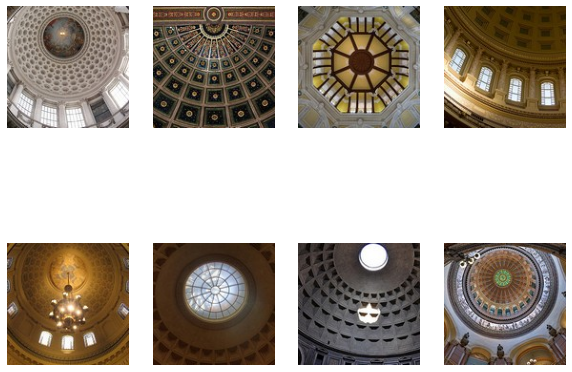

Category: gargoyle


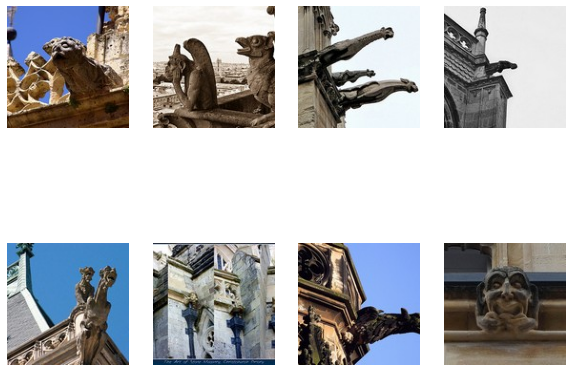

Category: column


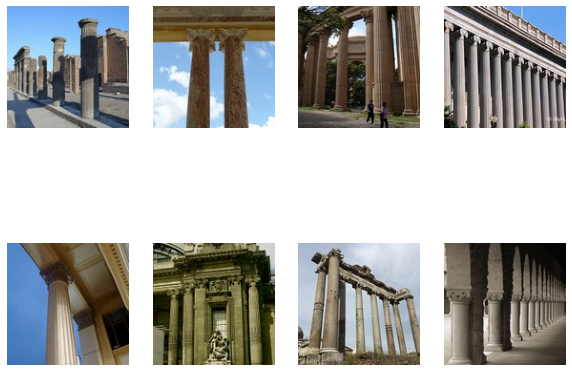

Category: stained_glass


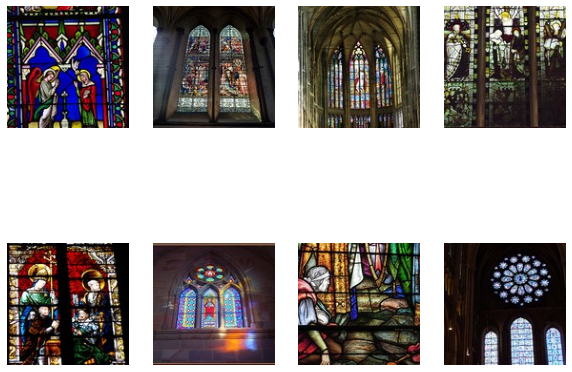

Category: apse


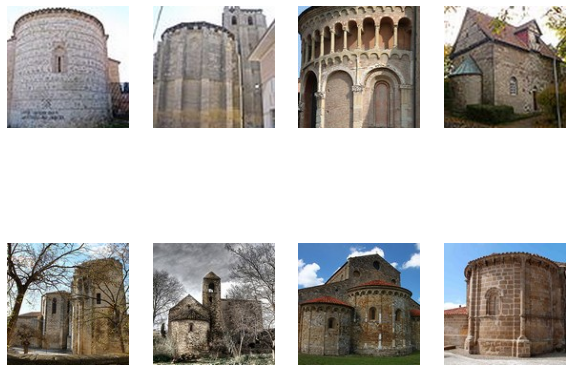

Category: dome(outer)


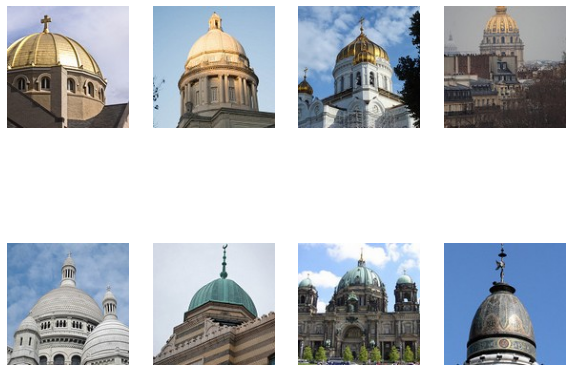

Category: bell_tower


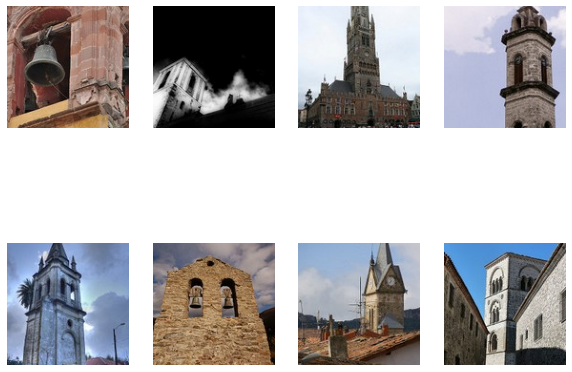

In [3]:
data_path = "dataset_hist_structures 2/dataset_hist_structures/Stuctures_Dataset/"
# List all the subdirectories
categories = [category for category in os.listdir(data_path) if not category.startswith('.')]

# Plot sample images from each category
for category in categories:
    category_path = os.path.join(data_path, category)
    images = [image for image in os.listdir(category_path) if not image.startswith('.')]
    print(f"Category: {category}")
    plt.figure(figsize=(10, 8))
    for i in range(min(8, len(images))):
        image = cv2.imread(os.path.join(category_path, images[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()


In [4]:
# Define paths
train_data_dir = "dataset_hist_structures 2/dataset_hist_structures/Stuctures_Dataset/"
validation_data_dir = "dataset_hist_structures 2/dataset_hist_structures/Dataset_test/Dataset_test_original_1478/"

def identify_and_remove_truncated_images(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                filepath = os.path.join(folder_path, filename)
                if os.path.isfile(filepath) and not filename.startswith('.'):
                    try:
                        img = Image.open(filepath)
                        img.load()
                    except (OSError, IOError) as e:
                        print(f"Removing corrupted image {filename}: {str(e)}")
                        os.remove(filepath)

# Apply the function to both directories
identify_and_remove_truncated_images(train_data_dir)
identify_and_remove_truncated_images(validation_data_dir)


Removing corrupted image d90864d8-0ae9-4929-b928-8e30fa7ea93f.jpg: image file is truncated (3 bytes not processed)
Removing corrupted image 0de19007-c9f0-4548-b070-7f67c55443de.jpg: image file is truncated (2 bytes not processed)
Removing corrupted image 9d1de848-bfd8-40e1-9686-0f8aba896655.jpg: cannot identify image file 'dataset_hist_structures 2/dataset_hist_structures/Dataset_test/Dataset_test_original_1478/stained_glass/9d1de848-bfd8-40e1-9686-0f8aba896655.jpg'
Removing corrupted image ren_tmp_jpg.bat: cannot identify image file 'dataset_hist_structures 2/dataset_hist_structures/Dataset_test/Dataset_test_original_1478/bell_tower/ren_tmp_jpg.bat'


#### Select and configure an CNN architecture for transfer learning. Set up a tensorflow environment for the selected architecture and load pre-trained weights.

In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#### Freeze all the convolutional layers' weight

In [6]:
for layer in base_model.layers:
    layer.trainable = False


#### Add dense layers and dropout for regularization

In [7]:
num_classes= 10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(base_model)  # Add the pre-trained VGG16 (or base model)
model.add(Flatten())  # Flatten the 2D feature maps into a 1D vector
model.add(Dense(256, activation='relu'))  # Fully connected layer with ReLU activation
model.add(Dropout(0.5))  # Dropout layer for regularization to reduce overfitting
model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification

#### Compile the model

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Define callback class to stop the training once the validation accuracy reaches a ceratin number

In [9]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)  # You can adjust the patience according to your preference


#### Set up train and test dataset directories and review the number of image samples for train and test set.Train the model without augmentation while continuously monitoring the validation accuracy.

In [10]:
batch_size=128
epochs=2


In [12]:
# Preprocess training and validation images for MobileNetV2
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Ensure only overlapping classes between train and validation sets
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Find overlapping classes between train and validation datasets
overlap_classes = list(set(train_generator.class_indices.keys()) & set(validation_generator.class_indices.keys()))

# Reconstruct generators to only include overlapping classes
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=overlap_classes
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=overlap_classes
)


Found 10235 images belonging to 10 classes.
Found 1473 images belonging to 10 classes.
Found 10235 images belonging to 10 classes.
Found 1473 images belonging to 10 classes.


In [13]:
history= model.fit(train_generator, epochs=epochs, 
          validation_data=validation_generator,
     
          callbacks=[early_stopping],
          batch_size=batch_size)

Epoch 1/2
80/80 [==============================] - 155s 2s/step - loss: 1.6673 - accuracy: 0.8137 - val_loss: 0.3196 - val_accuracy: 0.9138
Epoch 2/2
80/80 [==============================] - 151s 2s/step - loss: 0.2898 - accuracy: 0.9176 - val_loss: 0.3356 - val_accuracy: 0.9260


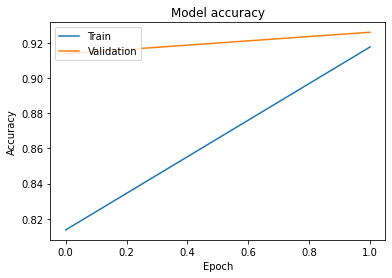

In [14]:
# The 'history' is the variable storing the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Train model with augmentation and keep monitoring validation accuracy.

In [15]:
train_datagen_aug = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator_aug = train_datagen_aug.flow_from_directory(
        train_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

history=model.fit(train_generator_aug, epochs=epochs, validation_data=validation_generator, callbacks=[early_stopping])


Found 10235 images belonging to 10 classes.
Epoch 1/2
80/80 [==============================] - 220s 3s/step - loss: 1.9761 - accuracy: 0.4507 - val_loss: 4.0426 - val_accuracy: 0.0720
Epoch 2/2
80/80 [==============================] - 219s 3s/step - loss: 1.2756 - accuracy: 0.5748 - val_loss: 5.4139 - val_accuracy: 0.0815


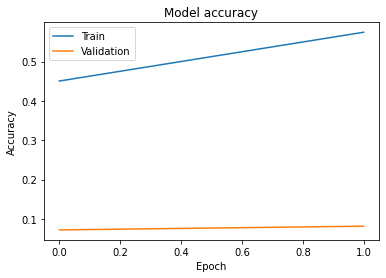

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

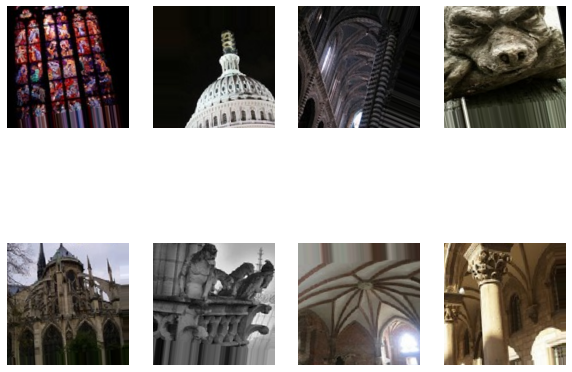

In [17]:
augmented_images, _ = next(train_generator_aug)
plt.figure(figsize=(10, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

#### Visualize training and validation accuracy on y-axis against each epoch on the x-axis to see if the model overfits after a certain epoch.

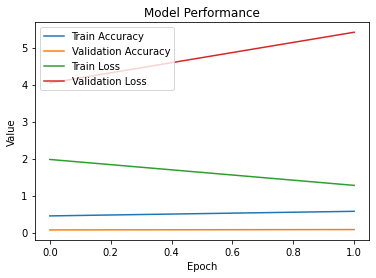

In [18]:
# Assuming 'history' is the variable storing the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Performance')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


## __Note:__ 
This code defines a function, create_small_dataset, which creates a smaller subset of an image dataset by copying a limited number of images from each class in the source dataset to a destination directory. This is useful for testing and experimentation, as working with a smaller dataset can significantly reduce training and processing time.

In [19]:
def create_small_dataset(src_dir, dest_dir, num_images_per_class=10):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        if os.path.isdir(class_path):
            dest_class_path = os.path.join(dest_dir, class_name)
            if not os.path.exists(dest_class_path):
                os.makedirs(dest_class_path)

            # Copy only 10 images
            for i, img_file in enumerate(os.listdir(class_path)):
                if i >= num_images_per_class:
                    break
                src_img_path = os.path.join(class_path, img_file)
                dest_img_path = os.path.join(dest_class_path, img_file)
                shutil.copy(src_img_path, dest_img_path)

# Use the function to create a small dataset
src_data_dir = "dataset_hist_structures 2/dataset_hist_structures/Stuctures_Dataset/"
small_data_dir = "SMALL_"+src_data_dir
create_small_dataset(src_data_dir, small_data_dir, num_images_per_class=10)


src_data_dir = "dataset_hist_structures 2/dataset_hist_structures/Dataset_test/Dataset_test_original_1478/"
small_data_dir = "SMALL_"+src_data_dir
create_small_dataset(src_data_dir, small_data_dir, num_images_per_class=10)